### **Imports Made**:
- Numpy for general purpose tasks (ex: file loads, matrix operations and arrangements, etc)
- sklearn.linear_model for the multiple models tested
- sklearn.model_selection for hyperparameter tuning and SSE calculation

All model selection methods were utilized at some point, but **train_test_split** proved to be the best tool for this situation.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

### **Data Extraction**:

Input files are loaded into variables *x*, *y* and *x_project*, this last one being from the *x_test* file. Commented below is a subset of code that performs outlier removal of two points who in a previous analysis were thought to be harmful for our model. But later these points did appear to have a degree of importance, especially due to them being similar to a couple of points in the testing samples. What is not commented, is the removal of four features from x_train and x_test, these same features from analysis through lasso revealed to be a little bit harmful to the SSE of our model. Thus, removing said dimensions improves our accuracy while still keeping our model structured and secure.

<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>


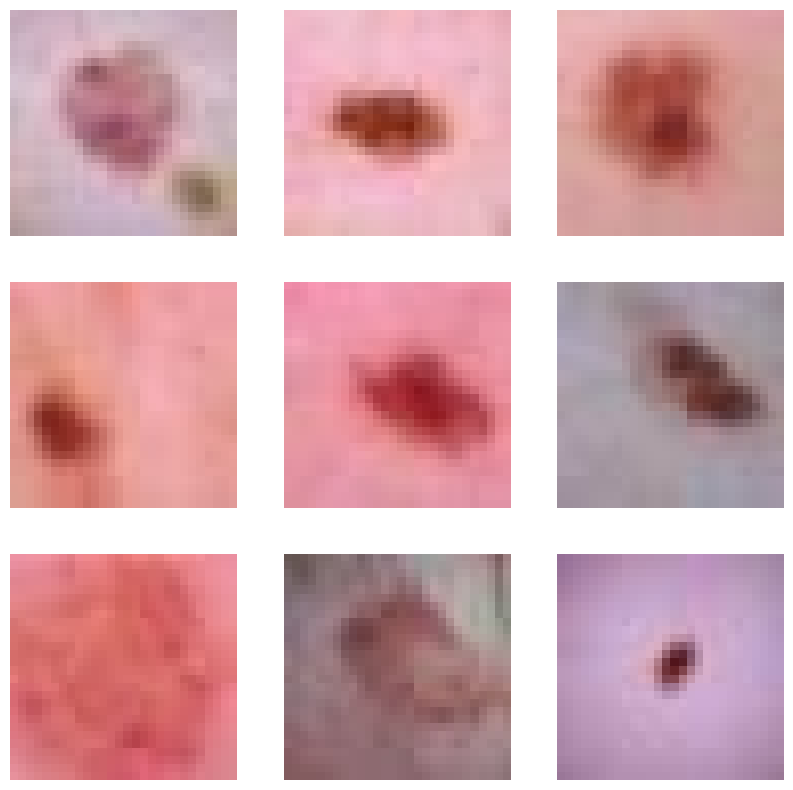

In [24]:
# Load data
x = np.load("Xtrain_Classification1.npy")
y = np.load("ytrain_Classification1.npy")
x_project = np.load("Xtest_Classification1.npy")
BATCH_SIZE = x.shape[0]
IMG_SIZE = (28, 28)
images = np.reshape(x,(len(x),28,28,3))
train_dataset = tf.data.Dataset.from_tensor_slices((images, y))
print(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

